In [29]:
#IMPORT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import corner
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA


In [2]:
#GENERAL OUTLINE
#
# import data and successfully extract from .txt using pandas DONE
#
# data exploration; look into dimensionality reduction (LOOP BACK)
#
# when cleared, proceed to SVM for classification
#
# hyperparameter optimization, feature engineering? nested CV?
#
# 

In [3]:
#csv so automatic reading works.
#Remember to only read a limited number of rows when exploring to avoid crashes!
datatest = pd.read_csv('table_irsa_catalog_search_results(1).csv', on_bad_lines='warn')
datatest = datatest.drop(datatest.index[datatest['ir1_flux_c'] <= 0])
datatest = datatest.drop(datatest.index[datatest['ir2_flux_c'] <= 0])
datatest = datatest.drop(datatest.index[datatest['ir3_flux_c'] <= 0])
datatest = datatest.drop(datatest.index[datatest['ir4_flux_c'] <= 0])
datatest = datatest.drop(datatest.index[datatest['mp1_flux_c'] <= 0])

In [4]:
pd.set_option('display.max_colwidth', 500) #to stop curtailing of data

In [5]:
datatest.describe()

,ra,dec,ir1_flux_c,ir1_d_flux_c,ir2_flux_c,ir2_d_flux_c,ir3_flux_c,ir3_d_flux_c,ir4_flux_c,ir4_d_flux_c,mp1_flux_c,mp1_d_flux_c
count,598578.000000,598578.000000,598578.000000,598578.000000,598578.000000,598578.000000,598578.000000,598578.000000,598578.000000,598578.000000,598578.000000,598578.00000
mean,218.350056,-20.238826,1.315107,0.084163,0.888998,0.054911,0.765612,0.076940,0.583351,0.084813,0.717619,0.41173
std,69.324435,27.218183,29.677483,2.978345,20.301463,1.337579,21.200348,1.391463,18.593867,1.227259,29.250333,3.62904
min,51.076973,-78.229538,0.000001,0.000030,0.000001,0.000023,0.000001,0.000131,0.000001,0.004460,0.000001,0.08410
25%,235.464401,-34.807583,0.019900,0.005460,0.015600,0.006360,0.019200,0.032000,0.016000,0.043700,0.062400,0.26900
50%,245.492798,-24.287815,0.049000,0.007060,0.035500,0.007850,0.040000,0.040000,0.033900,0.053400,0.135000,0.32700
75%,248.418465,-0.130489,0.128000,0.010700,0.089800,0.010200,0.077100,0.046500,0.069100,0.061200,0.249000,0.37300
max,277.667328,32.976467,8000.000000,1100.000000,3960.000000,358.000000,5500.000000,433.000000,3830.000000,361.000000,6860.000000,1150.00000


In [6]:
datatest.columns

Index(['c2d_id', 'ra', 'dec', 'object_type', 'ir1_flux_c', 'ir1_d_flux_c',
       'ir1_q_det_c', 'ir2_flux_c', 'ir2_d_flux_c', 'ir2_q_det_c',
       'ir3_flux_c', 'ir3_d_flux_c', 'ir3_q_det_c', 'ir4_flux_c',
       'ir4_d_flux_c', 'ir4_q_det_c', 'mp1_flux_c', 'mp1_d_flux_c',
       'mp1_q_det_c'],
      dtype='object')

In [7]:
print(datatest['object_type'][:10])
colors = [int(re.sub('\W', '', string), 36) for string in datatest['object_type']]
print(colors[:10])
print(datatest['object_type'].str[:3].unique().tolist())

4      two
5      two
6     star
7      one
8      two
9      two
12     two
13    star
16     two
23     one
Name: object_type, dtype: object
[38760, 38760, 1344339, 31946, 38760, 38760, 38760, 1344339, 38760, 31946]
['two', 'sta', 'one', 'fla', 'Gal', 'red', 'cup', 'PAH', 'YSO', 'ris', 'fal']


In [8]:
def simplelabel(row):
    '''
    DO LATER
    '''
    type = row['object_type'][:3]
    #remove "non interesting" sources
    #or confusing ones with no clear provenance
    if type == 'one':
        return 0
    if type == 'two':
        return 0
    if type == 'red':
        return 0
    if type == 'PAH':
        return 0
    #designate stars
    if type == 'sta':
        return 1
    #designate galaxies
    if type == 'Gal':
        return 2
    #designate YSOs
    if type == 'YSO':
        return 3
    if type == 'fla':
        return 0
    if type == 'cup':
        return 0
    if type == 'ris':
        return 0
    if type == 'fal':
        return 0
    return 4

In [9]:
datatest['numtype'] = datatest.apply(simplelabel, axis=1)


In [10]:
print(datatest['numtype'].unique().tolist())
print(datatest['numtype'].value_counts())

[0, 1, 2, 3]
numtype
0    454197
1    140329
2      2965
3      1087
Name: count, dtype: int64


In [11]:
datatest = datatest.drop(datatest.index[datatest['numtype'] == 0])

In [12]:
datatest.describe()

,ra,dec,ir1_flux_c,ir1_d_flux_c,ir2_flux_c,ir2_d_flux_c,ir3_flux_c,ir3_d_flux_c,ir4_flux_c,ir4_d_flux_c,mp1_flux_c,mp1_d_flux_c,numtype
count,144381.000000,144381.000000,144381.000000,144381.000000,144381.000000,144381.000000,144381.000000,144381.000000,144381.000000,144381.000000,144381.000000,144381.000000,144381.000000
mean,229.618357,-22.931583,5.302005,0.326341,3.570255,0.202236,3.042933,0.183543,2.235395,0.162438,2.095330,0.534772,1.035593
std,58.554049,25.627650,60.247826,6.057572,41.189997,2.711268,43.036855,2.587201,36.775939,2.257443,55.674164,6.103550,0.222225
min,51.096821,-78.229538,0.001220,0.002630,0.000383,0.003150,0.000004,0.000191,0.000003,0.012700,0.000001,0.136000,1.000000
25%,240.045746,-38.433178,0.177000,0.011500,0.121000,0.009700,0.085700,0.030300,0.049500,0.041900,0.061900,0.262000,1.000000
50%,245.480484,-24.410429,0.326000,0.019100,0.222000,0.014400,0.146000,0.037300,0.096400,0.052900,0.135000,0.320000,1.000000
75%,249.836166,-0.176496,0.907000,0.048700,0.609000,0.033300,0.432000,0.051400,0.277000,0.063300,0.255000,0.373000,1.000000
max,277.666534,32.972988,8000.000000,1100.000000,3960.000000,358.000000,5500.000000,369.000000,3830.000000,271.000000,6860.000000,1150.000000,3.000000


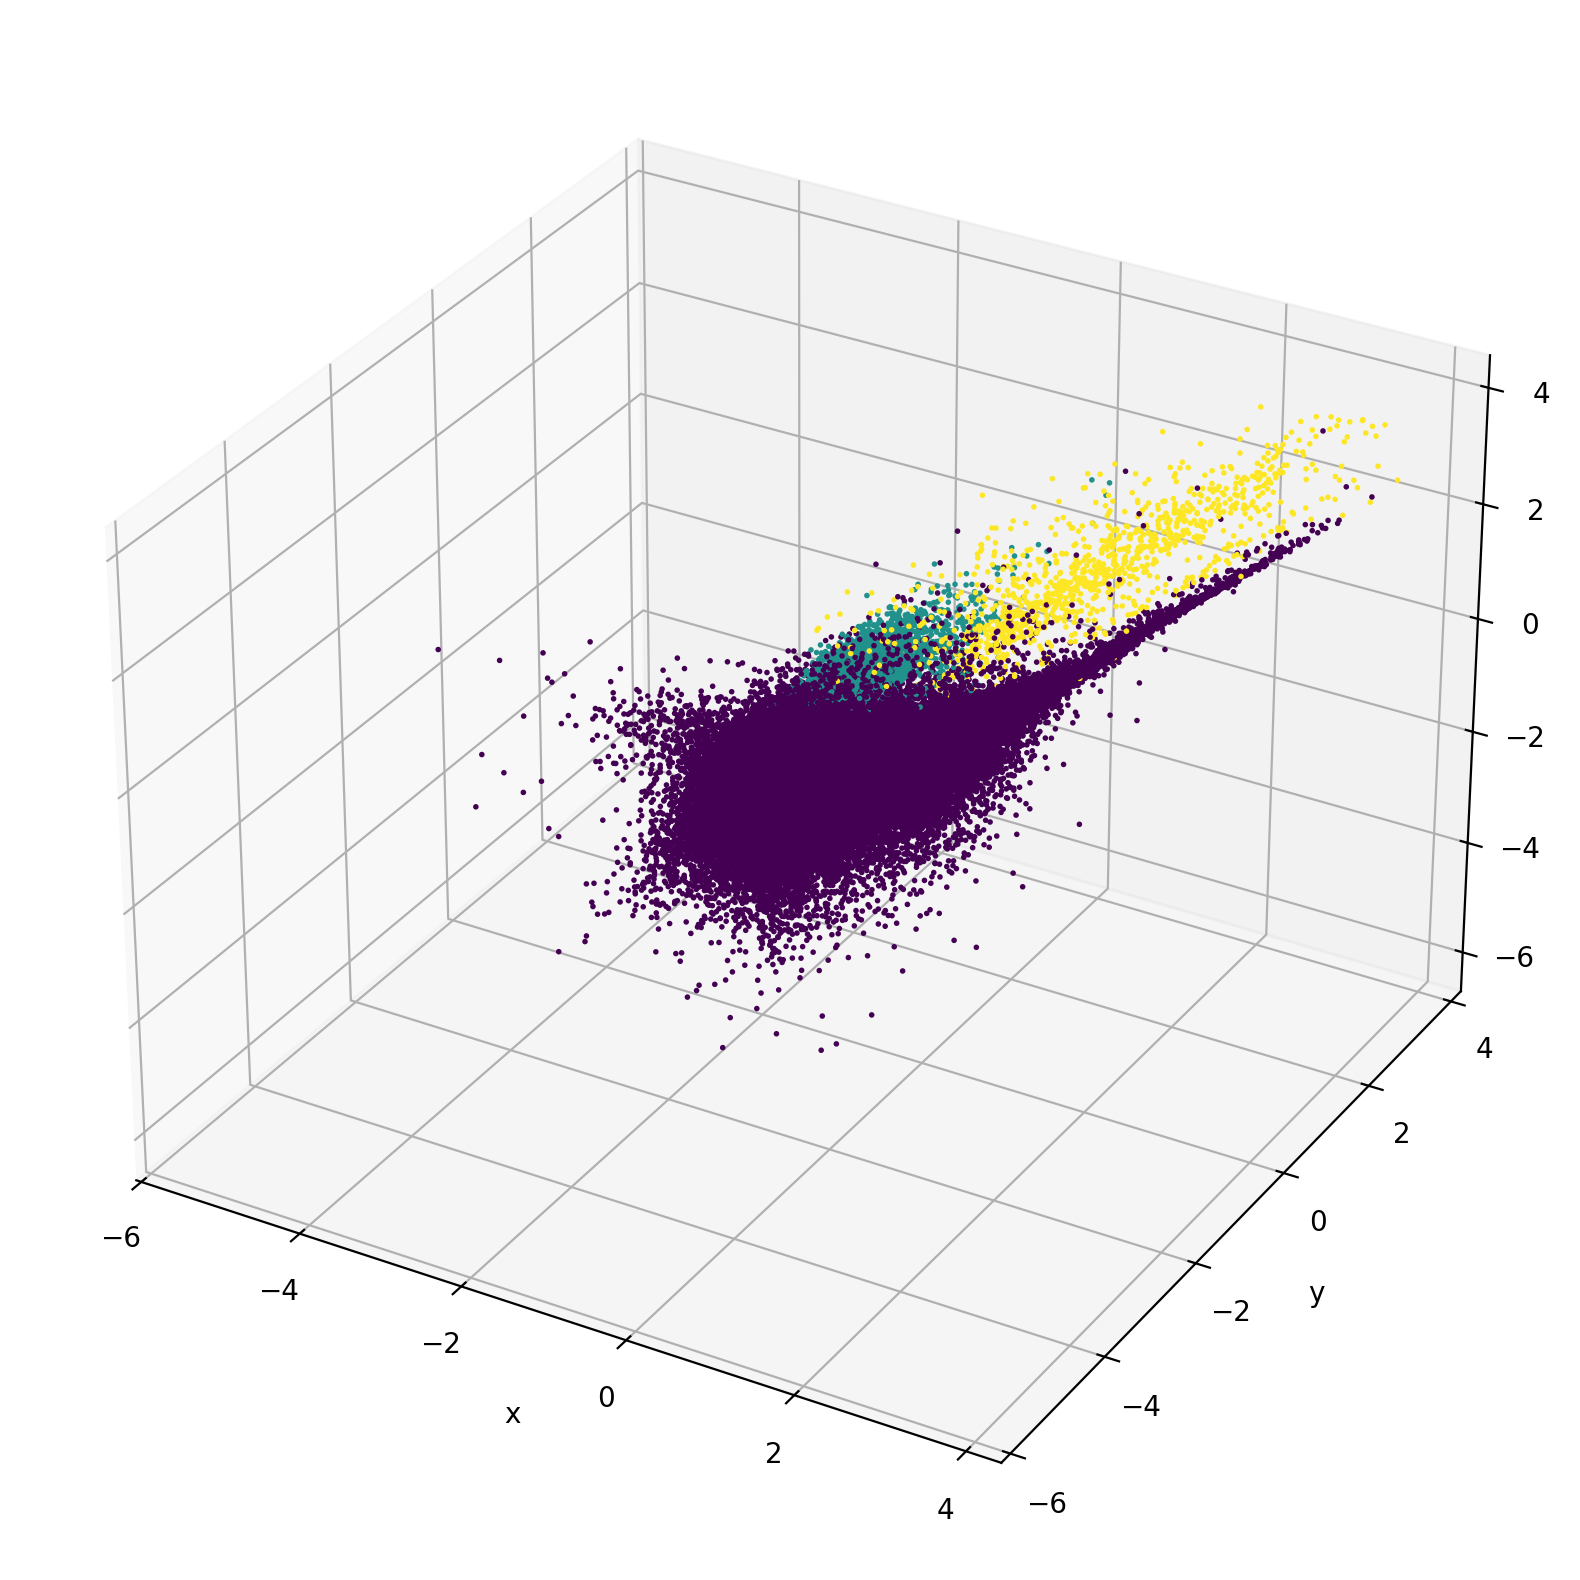

In [13]:
fig = plt.figure(figsize=(10,10), dpi=200)
ax = fig.add_subplot(projection='3d')

ax.scatter(np.log10(datatest['ir3_flux_c']), np.log10(datatest['ir4_flux_c']), np.log10(datatest['mp1_flux_c']), c=datatest['numtype'], alpha=1, s=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#ax.view_init(azim=-90)

plt.show()

In [14]:
datatest.loc[datatest['numtype'] == 3, 'ir3_flux_c']

2420        72.000000
5180         5.410000
5831        13.400000
5869        28.000000
12169        2.920000
              ...    
2267250     24.700001
2267556     35.900002
2267580    191.000000
2267703     11.600000
2268438     24.700001
Name: ir3_flux_c, Length: 1087, dtype: float64

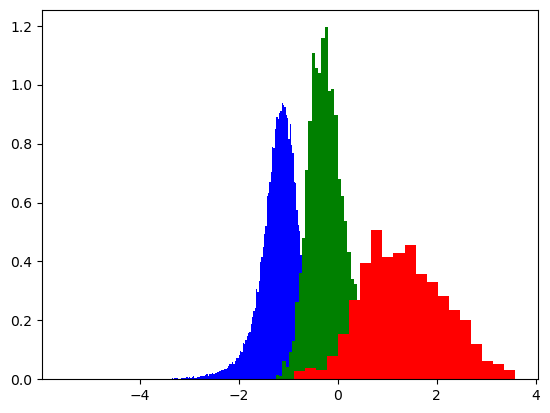

In [15]:

plt.hist(np.log10(datatest.loc[datatest['numtype'] == 1, 'ir4_flux_c']), bins='auto', density=True, color='blue')
plt.hist(np.log10(datatest.loc[datatest['numtype'] == 2, 'ir4_flux_c']), bins='auto', density=True, color='green')
plt.hist(np.log10(datatest.loc[datatest['numtype'] == 3, 'ir4_flux_c']), bins='auto', density=True, color='red')
plt.show()

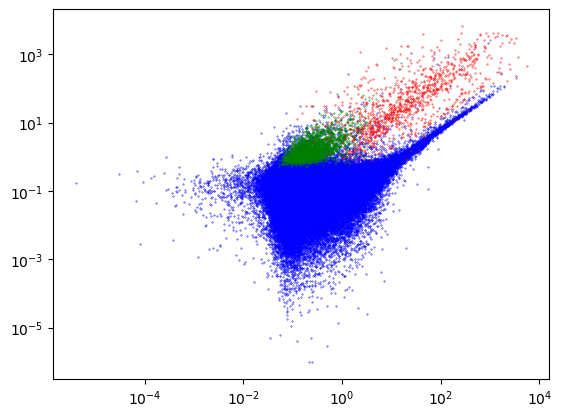

In [16]:
plt.scatter(np.array(datatest.loc[datatest['numtype'] == 1, 'ir3_flux_c']),np.array(datatest.loc[datatest['numtype'] == 1, 'mp1_flux_c']), s=.1, c='blue')
plt.scatter(np.array(datatest.loc[datatest['numtype'] == 2, 'ir3_flux_c']),np.array(datatest.loc[datatest['numtype'] == 2, 'mp1_flux_c']), s=.1, c='green')
plt.scatter(np.array(datatest.loc[datatest['numtype'] == 3, 'ir3_flux_c']),np.array(datatest.loc[datatest['numtype'] == 3, 'mp1_flux_c']), s=.1, c='red')
plt.loglog()
plt.show()

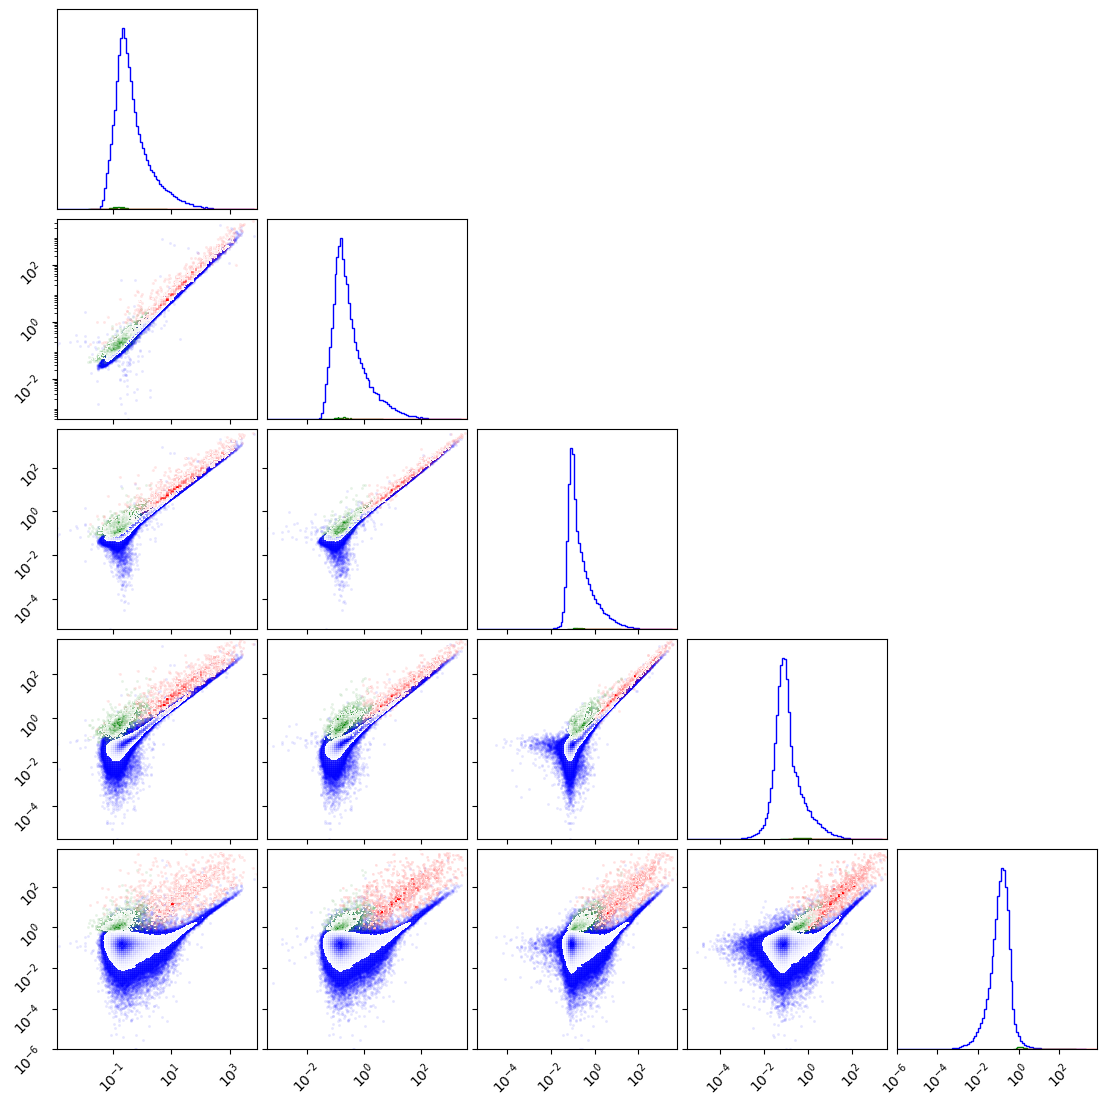

In [17]:
samplesStar = np.hstack((np.array(datatest.loc[datatest['numtype'] == 1, 'ir1_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 1, 'ir2_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 1, 'ir3_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 1, 'ir4_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 1, 'mp1_flux_c']).reshape(-1, 1)))
samplesGal = np.hstack((np.array(datatest.loc[datatest['numtype'] == 2, 'ir1_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 2, 'ir2_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 2, 'ir3_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 2, 'ir4_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 2, 'mp1_flux_c']).reshape(-1, 1)))
samplesYSO = np.hstack((np.array(datatest.loc[datatest['numtype'] == 3, 'ir1_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 3, 'ir2_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 3, 'ir3_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 3, 'ir4_flux_c']).reshape(-1, 1),
                     np.array(datatest.loc[datatest['numtype'] == 3, 'mp1_flux_c']).reshape(-1, 1)))

figure = corner.corner(samplesStar, axes_scale='log', plot_contours=False, color='blue', bins=100)
corner.corner(samplesGal,fig=figure, axes_scale='log', plot_contours=False, color='green', bins=100)
corner.corner(samplesYSO,fig=figure, axes_scale='log', plot_contours=False, color='red', bins=100)
plt.show()

In [18]:
#Enough pain. Let us begin actually machine learning

In [58]:
clf = LinearSVC(dual = False)
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101) 
X = np.vstack((np.log10(datatest['ir1_flux_c']), np.log10(datatest['ir2_flux_c']), np.log10(datatest['ir3_flux_c']),
              np.log10(datatest['ir4_flux_c']),np.log10(datatest['mp1_flux_c']))).T
print(X.shape)
print(X)
Y = np.array(datatest['numtype'])-1
print(Y)
clf.fit(X, Y)

(144381, 5)
[[ 0.06069784 -0.09908693 -0.25103714 -0.50584541 -1.24641694]
 [-1.13430394 -1.34294415 -1.35951856 -2.0619809  -0.75448733]
 [-0.35066514 -0.54668166 -0.7235382  -1.01502287 -1.18508682]
 ...
 [ 0.66745295  0.5171959   0.35602586  0.15836249 -0.78515615]
 [-0.91009489 -1.04769199 -1.26921772 -1.4867824  -0.61439373]
 [-0.79317412 -0.9625735  -1.11350927 -1.70774393 -1.01099538]]
[0 0 0 ... 0 0 0]


LinearSVC(dual=False)

In [59]:
fauxgrid = np.linspace(-3, 3, 10)
g = np.meshgrid(fauxgrid, fauxgrid, fauxgrid, fauxgrid, fauxgrid)
Xnew = np.vstack([np.ravel(i) for i in g]).T
print(Xnew)
carray = clf.predict(np.array((np.log10(datatest['ir1_flux_c']), np.log10(datatest['ir2_flux_c']), np.log10(datatest['ir3_flux_c']),np.log10(datatest['ir4_flux_c']),np.log10(datatest['mp1_flux_c']))).T)

[[-3.         -3.         -3.         -3.         -3.        ]
 [-3.         -3.         -3.         -3.         -2.33333333]
 [-3.         -3.         -3.         -3.         -1.66666667]
 ...
 [ 3.          3.          3.          3.          1.66666667]
 [ 3.          3.          3.          3.          2.33333333]
 [ 3.          3.          3.          3.          3.        ]]


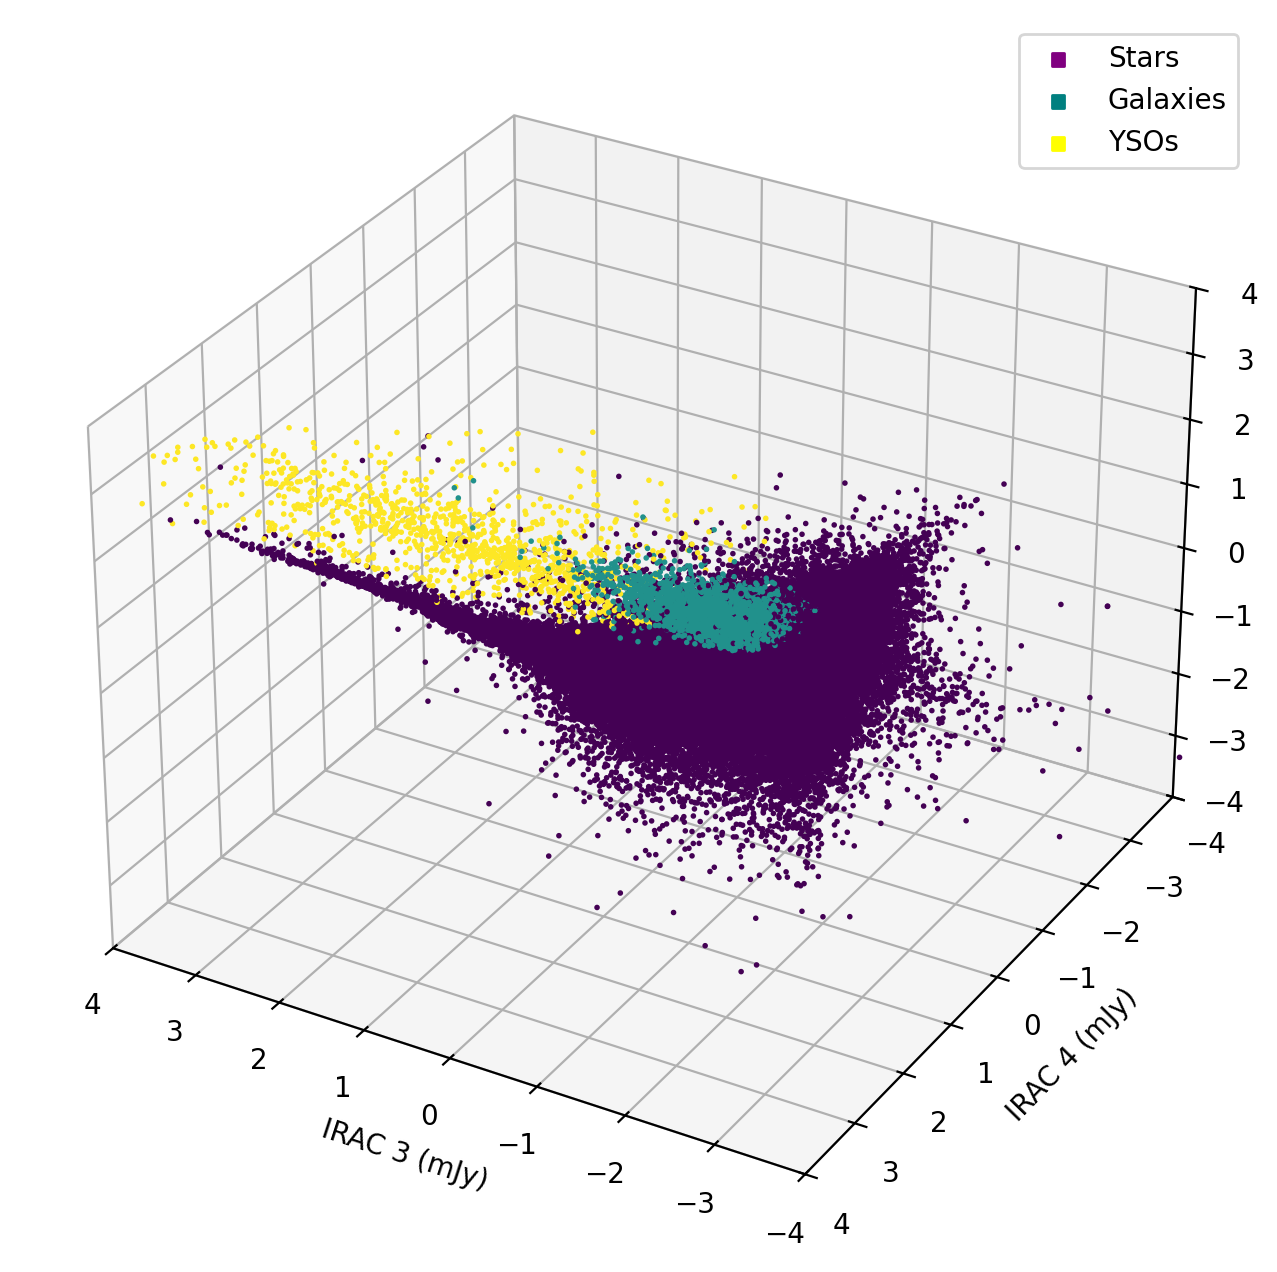

In [60]:
fig = plt.figure(figsize=(9,8), dpi=200)
ax  = fig.add_subplot(111, projection='3d')
#ax.scatter(g[0].T, g[1].T, g[2].T, c=clf.predict(Xnew)) 
#ax.scatter(X[Y==0,0], X[Y==0,1], X[Y==0,2], s=.1, color='blue')
#ax.scatter(X[Y==1,0], X[Y==1,1], X[Y==1,2],'sr', s=.1, color='green')
#ax.scatter(X[Y==2,0], X[Y==2,1], X[Y==2,2],'br', s=.1, color='red')

#ax.scatter(np.log10(datatest['ir1_flux_c']), np.log10(datatest['ir2_flux_c']), np.log10(datatest['ir3_flux_c']), c=carray, alpha=1, s=1)
ax.scatter(np.log10(datatest['ir3_flux_c']), np.log10(datatest['ir4_flux_c']), np.log10(datatest['mp1_flux_c']), c=datatest['numtype'], alpha=1, s=1)
ax.set_xlabel('IRAC 3 (mJy)')
ax.set_ylabel('IRAC 4 (mJy)')
ax.set_zlabel('MIPS 1 (mJy)')
ax.set_xlim(4, -4)
ax.set_ylim(4, -4)
ax.set_zlim(-4, 4)
STR = ax.scatter([], [], color='purple', marker='s', ls='', label='Stars')
GAL = ax.scatter([], [], color='teal', marker='s', ls='', label='Galaxies')
YSO = ax.scatter([], [], color='yellow', marker='s', ls='', label='YSOs')
plt.legend(handles=[STR, GAL, YSO])
plt.show()

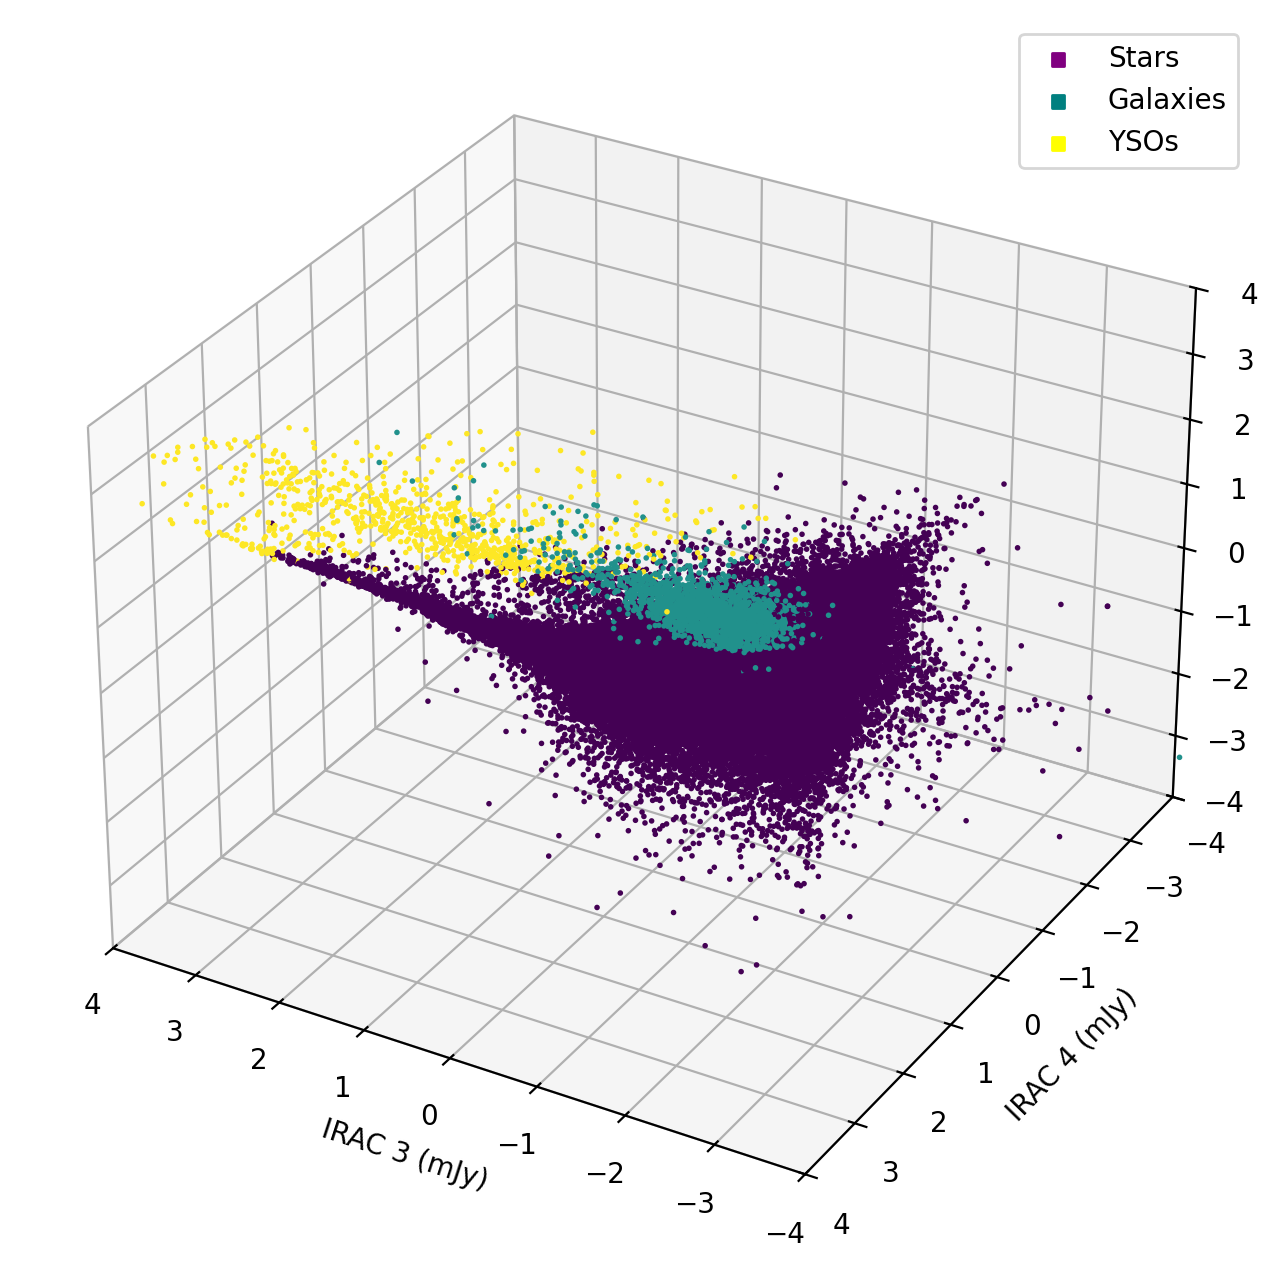

In [61]:
fig = plt.figure(figsize=(9,8), dpi=200)
ax  = fig.add_subplot(111, projection='3d')
#ax.scatter(g[0].T, g[1].T, g[2].T, c=clf.predict(Xnew)) 
#ax.scatter(X[Y==0,0], X[Y==0,1], X[Y==0,2], s=.1, color='blue')
#ax.scatter(X[Y==1,0], X[Y==1,1], X[Y==1,2],'sr', s=.1, color='green')
#ax.scatter(X[Y==2,0], X[Y==2,1], X[Y==2,2],'br', s=.1, color='red')

ax.scatter(np.log10(datatest['ir3_flux_c']), np.log10(datatest['ir4_flux_c']), np.log10(datatest['mp1_flux_c']), c=carray, alpha=1, s=1)
#ax.scatter(np.log10(datatest['ir1_flux_c']), np.log10(datatest['ir2_flux_c']), np.log10(datatest['ir3_flux_c']), c=datatest['numtype'], alpha=1, s=1)
ax.set_xlabel('IRAC 3 (mJy)')
ax.set_ylabel('IRAC 4 (mJy)')
ax.set_zlabel('MIPS 1 (mJy)')
ax.set_xlim(4, -4)
ax.set_ylim(4, -4)
ax.set_zlim(-4, 4)
STR = ax.scatter([], [], color='purple', marker='s', ls='', label='Stars')
GAL = ax.scatter([], [], color='teal', marker='s', ls='', label='Galaxies')
YSO = ax.scatter([], [], color='yellow', marker='s', ls='', label='YSOs')
plt.legend(handles=[STR, GAL, YSO])
plt.show()

In [24]:
print(np.array(X[:, 0:2]).T)

[[ 0.06069784 -1.13430394 -0.35066514 ...  0.66745295 -0.91009489
  -0.79317412]
 [-0.09908693 -1.34294415 -0.54668166 ...  0.5171959  -1.04769199
  -0.9625735 ]]


In [62]:
clf = SVC(kernel='rbf')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101) 

l_benchmark_lim = cross_validate(clf, X, Y, cv = cv, return_train_score = True)

print("Training score: {} +/- {}".format(
    np.round(l_benchmark_lim['train_score'].mean(),7), np.round(l_benchmark_lim['train_score'].std(), 7)))

print("Testing score: {} +/- {}".format(
    np.round(l_benchmark_lim['test_score'].mean(),7), np.round(l_benchmark_lim['test_score'].std(), 7)))

Training score: 0.9920731 +/- 0.0002011
Testing score: 0.9920488 +/- 0.0006894


In [ ]:
#use PCA to plot 2dlike

In [35]:

X = np.vstack((np.log10(datatest['ir1_flux_c']), np.log10(datatest['ir2_flux_c']), np.log10(datatest['ir3_flux_c']),
              np.log10(datatest['ir4_flux_c']),np.log10(datatest['mp1_flux_c']))).T
pca = PCA(n_components=2)

XPCA = pca.fit_transform(X)
print(XPCA)

[[ 0.66434704 -0.49384688]
 [-1.73310863  0.50283389]
 [-0.22303067 -0.24446586]
 ...
 [ 1.98205263 -0.31064415]
 [-1.11379598  0.53870102]
 [-1.14172497  0.11058475]]


In [63]:
clf = SVC(kernel='rbf')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101) 

l_benchmark_lim = cross_validate(clf, XPCA, Y, cv = cv, return_train_score = True)

print("Training score: {} +/- {}".format(
    np.round(l_benchmark_lim['train_score'].mean(),7), np.round(l_benchmark_lim['train_score'].std(), 7)))

print("Testing score: {} +/- {}".format(
    np.round(l_benchmark_lim['test_score'].mean(),7), np.round(l_benchmark_lim['test_score'].std(), 7)))

Training score: 0.9907311 +/- 0.0001092
Testing score: 0.990629 +/- 0.0005026


In [64]:
print(XPCA[:,0])

[ 0.66434704 -1.73310863 -0.22303067 ...  1.98205263 -1.11379598
 -1.14172497]


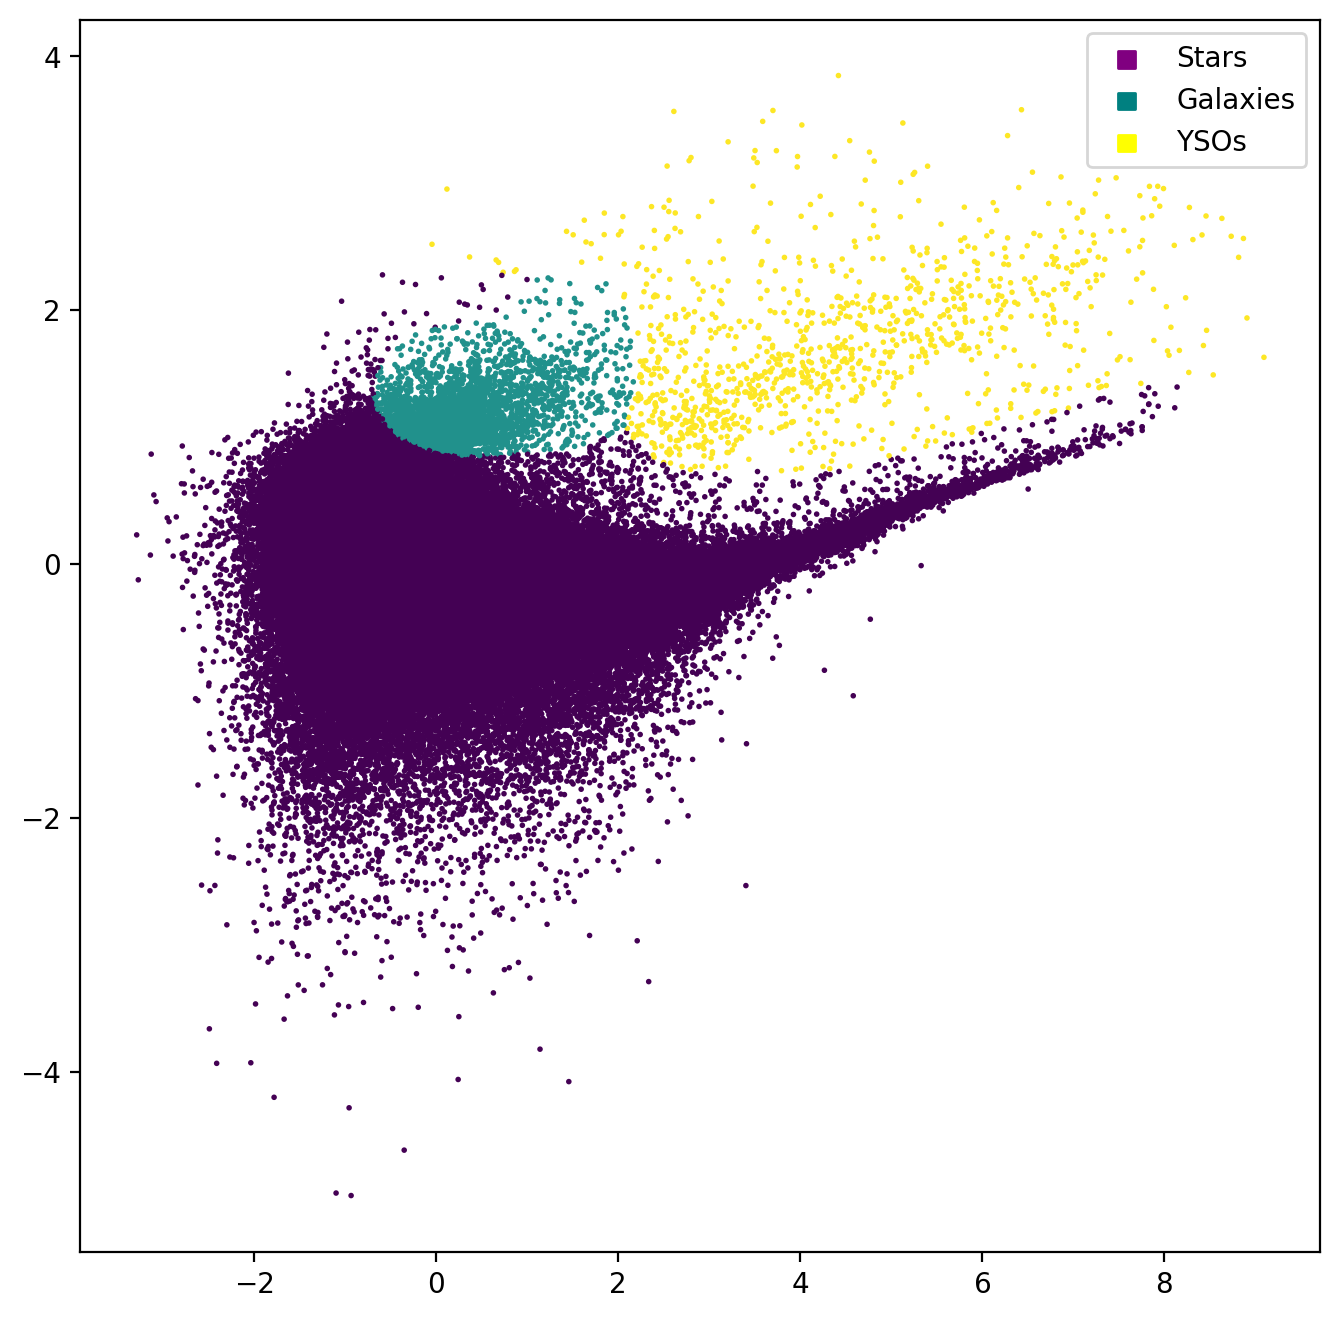

In [68]:
clf.fit(XPCA, Y)
carray = clf.predict(XPCA).T
z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]

tmp = np.linspace(-5,5,30)
x,y = np.meshgrid(tmp,tmp)

fig = plt.figure(figsize=(8,8), dpi=200)
ax  = fig.add_subplot(111)
#ax.scatter(g[0].T, g[1].T, g[2].T, c=clf.predict(Xnew)) 
#ax.scatter(X[Y==0,0], X[Y==0,1], X[Y==0,2], s=.1, color='blue')
#ax.scatter(X[Y==1,0], X[Y==1,1], X[Y==1,2],'sr', s=.1, color='green')
#ax.scatter(X[Y==2,0], X[Y==2,1], X[Y==2,2],'br', s=.1, color='red')

ax.scatter(XPCA[:,0],XPCA[:,1], c=carray, alpha=1, s=1)
#ax.scatter(np.log10(datatest['ir1_flux_c']), np.log10(datatest['ir2_flux_c']), np.log10(datatest['ir3_flux_c']), c=datatest['numtype'], alpha=1, s=1)

STR = ax.scatter([], [], color='purple', marker='s', ls='', label='Stars')
GAL = ax.scatter([], [], color='teal', marker='s', ls='', label='Galaxies')
YSO = ax.scatter([], [], color='yellow', marker='s', ls='', label='YSOs')
plt.legend(handles=[STR, GAL, YSO])
plt.show()

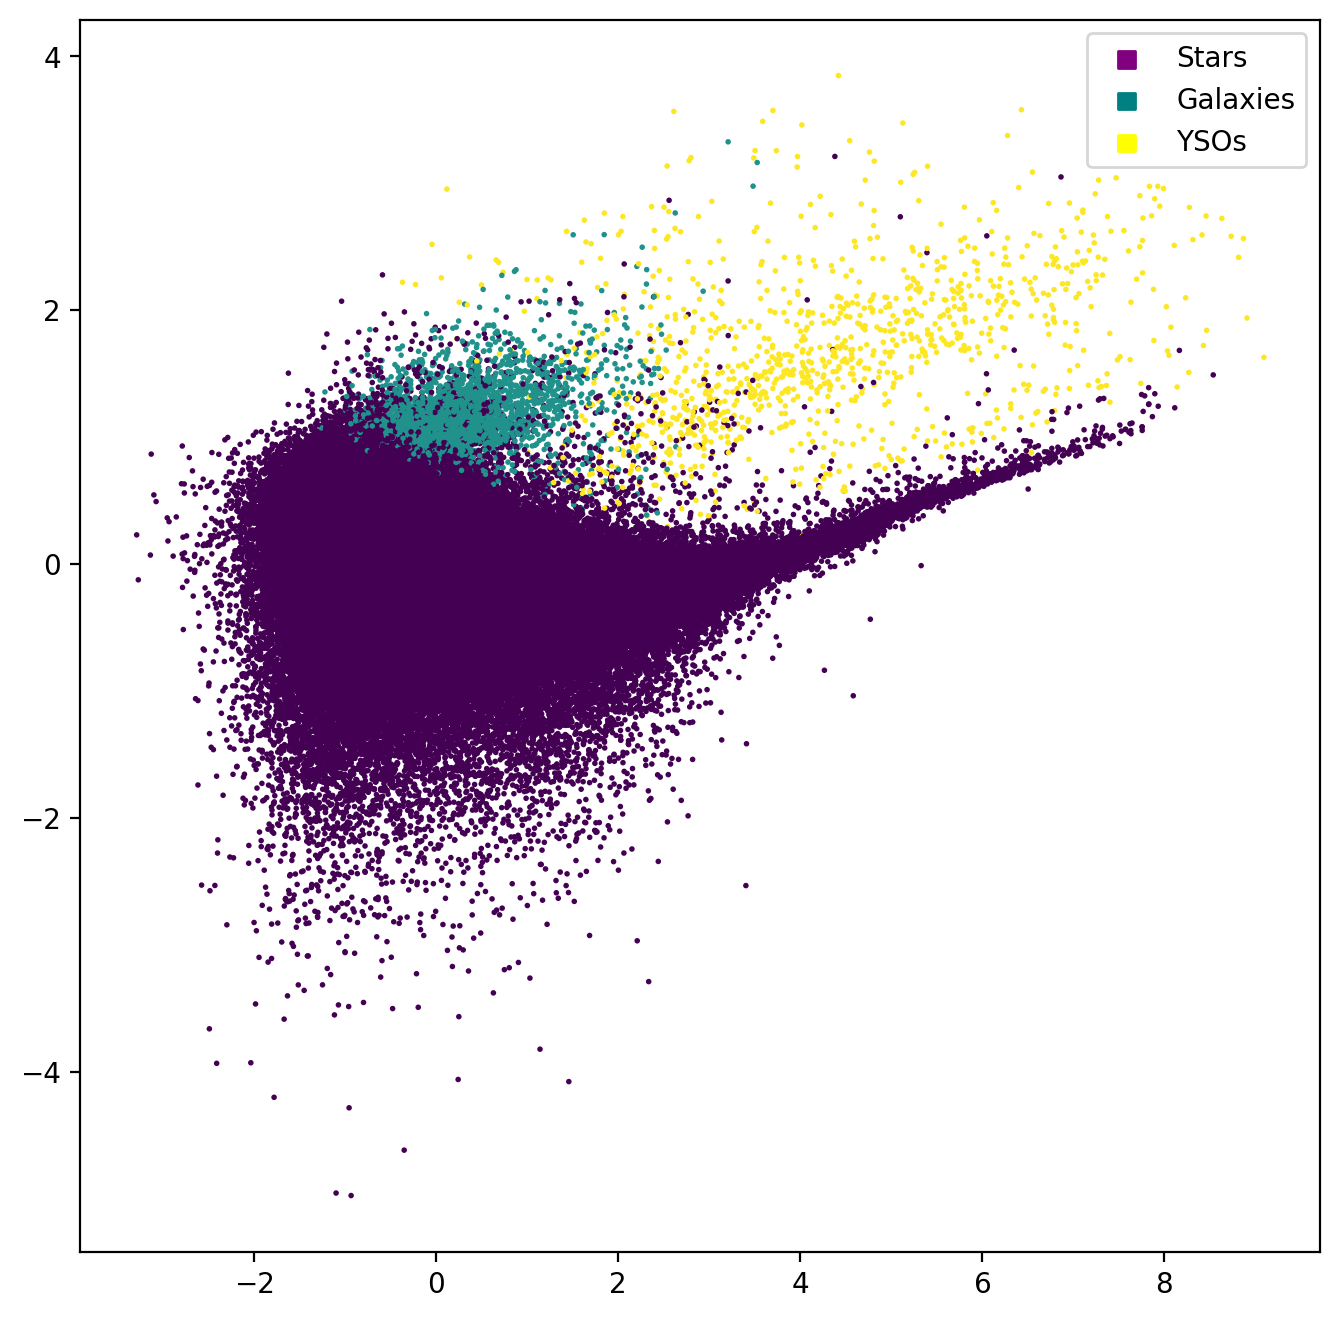

In [69]:
fig = plt.figure(figsize=(8,8), dpi=200)
ax  = fig.add_subplot(111)
#ax.scatter(g[0].T, g[1].T, g[2].T, c=clf.predict(Xnew)) 
#ax.scatter(X[Y==0,0], X[Y==0,1], X[Y==0,2], s=.1, color='blue')
#ax.scatter(X[Y==1,0], X[Y==1,1], X[Y==1,2],'sr', s=.1, color='green')
#ax.scatter(X[Y==2,0], X[Y==2,1], X[Y==2,2],'br', s=.1, color='red')

ax.scatter(XPCA[:,0],XPCA[:,1], c=datatest['numtype'], alpha=1, s=1)
#ax.scatter(np.log10(datatest['ir1_flux_c']), np.log10(datatest['ir2_flux_c']), np.log10(datatest['ir3_flux_c']), c=datatest['numtype'], alpha=1, s=1)
STR = ax.scatter([], [], color='purple', marker='s', ls='', label='Stars')
GAL = ax.scatter([], [], color='teal', marker='s', ls='', label='Galaxies')
YSO = ax.scatter([], [], color='yellow', marker='s', ls='', label='YSOs')
plt.legend(handles=[STR, GAL, YSO])

plt.show()

In [ ]:
#test different hyperparams such as kernel